# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

from scipy.stats import yeojohnson, yeojohnson_normmax
from scipy.stats.mstats import winsorize

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings

from pmdarima import auto_arima
from arch import arch_model

from joblib import Parallel, delayed

warnings.filterwarnings('ignore')

# Data Loading & Visualisation

### Data Loading

In [2]:
# Load the data
qqq = pd.read_excel('../data/qqq_data.xlsx', 
                    index_col=0, parse_dates=True)
macro = pd.read_excel('../data/macro_data.xlsx', 
                      index_col=0, parse_dates=True)

# Check the data
display(qqq.head())
display(macro.head())

,ETF_Ticker,ETF_Open,ETF_High,ETF_Low,ETF_Close,ETF_Volume,ETF_Return,Benchmark_Return,Benchmark_Volatility,Tracking_Error,...,Dividend_Yield_pct,Beta,Expense_Ratio_pct,Fund_Family,Fund_Category,Inception_Date,Pct_in_Top10_Holdings,Total_Holdings,Optionable,Shortable
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,QQQ,34.320947,34.492167,31.213309,32.018024,2234773200,-0.063126,-0.062605,0.010865,-0.000522,...,58.0,1.18,20,Invesco,Large Growth,1999-03-10,0.005014,101,True,True
2005-02-01,QQQ,32.095091,32.942606,31.418755,31.863935,1765610600,-0.004813,-0.005666,0.010056,0.000853,...,58.0,1.18,20,Invesco,Large Growth,1999-03-10,0.005014,101,True,True
2005-03-01,QQQ,31.992344,32.779963,30.768126,31.307474,2133973700,-0.017464,-0.018855,0.008751,0.001391,...,58.0,1.18,20,Invesco,Large Growth,1999-03-10,0.005014,101,True,True
2005-04-01,QQQ,31.521498,31.735519,29.406934,29.946276,2345433600,-0.043478,-0.041645,0.012613,-0.001833,...,58.0,1.18,20,Invesco,Large Growth,1999-03-10,0.005014,101,True,True
2005-05-01,QQQ,30.049009,32.762837,29.869230,32.600197,1881340000,0.088623,0.085755,0.006330,0.002868,...,58.0,1.18,20,Invesco,Large Growth,1999-03-10,0.005014,101,True,True


,vix,michigan_consumer_sentiment_index
2005-01-01,12.82,95.5
2005-02-01,12.08,94.1
2005-03-01,14.02,92.6
2005-04-01,15.31,87.7
2005-05-01,13.29,86.9


In [3]:
# Get information about the data
print("QQQ Data Info:")
display(qqq.describe())
print("\nMacro Data Info:")
display(macro.describe())

QQQ Data Info:


,ETF_Open,ETF_High,ETF_Low,ETF_Close,ETF_Volume,ETF_Return,Benchmark_Return,Benchmark_Volatility,Tracking_Error,Absolute_Tracking_Error,Net_Assets_USD,NAV_USD,PE_Ratio,Dividend_Yield_pct,Beta,Expense_Ratio_pct,Inception_Date,Pct_in_Top10_Holdings,Total_Holdings
count,240.000000,240.000000,240.000000,240.000000,2.400000e+02,240.000000,240.000000,240.000000,240.000000,240.000000,2.400000e+02,2.400000e+02,240.00000,240.0,240.00,240.0,240,240.000000,240.0
mean,141.854185,148.410727,135.854721,143.609570,1.380399e+09,0.012765,0.012160,0.012097,0.000605,0.001171,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
min,23.522952,26.702119,21.696006,23.878576,3.074376e+08,-0.155763,-0.162953,0.002915,-0.007349,0.000002,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
25%,41.132771,43.758852,39.327759,41.804646,6.974952e+08,-0.018018,-0.018936,0.007918,-0.000234,0.000434,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
50%,94.027525,97.665560,90.360646,95.052735,1.008536e+09,0.017680,0.017121,0.010193,0.000628,0.000892,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
75%,192.992068,208.999052,183.989309,198.462799,1.776189e+09,0.048497,0.047817,0.014446,0.001344,0.001540,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
max,509.427621,537.480547,507.712944,514.842224,7.240780e+09,0.149738,0.151918,0.057591,0.008237,0.008237,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
std,126.109204,132.364382,120.760418,127.951458,9.793356e+08,0.052866,0.052700,0.006933,0.001482,0.001090,0.000000e+00,1.139244e-13,0.00000,0.0,0.00,0.0,NaN,0.000000,0.0



Macro Data Info:


,vix,michigan_consumer_sentiment_index
count,240.000000,240.000000
mean,19.299542,80.122083
std,8.250237,12.798809
min,9.510000,50.000000
25%,13.535000,70.450000
50%,16.810000,80.200000
75%,22.990000,91.550000
max,59.889999,101.400000


In [4]:
# y=0 dashed line
def add_zero_line(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.axhline(0, linestyle='--', color='gray', linewidth=1)

### Plots

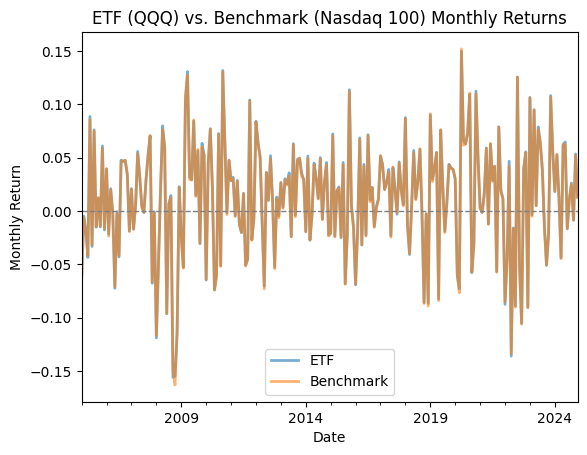

In [5]:
# ETF Returns vs Benchmark Returns
plt.figure()
ax = qqq['ETF_Return'].plot(alpha=0.6, linewidth=2, label='ETF')
qqq['Benchmark_Return'].plot(alpha=0.6, linewidth=2, label='Benchmark', ax=ax)
add_zero_line(ax)
plt.title('ETF (QQQ) vs. Benchmark (Nasdaq 100) Monthly Returns')
plt.xlabel('Date'); plt.ylabel('Monthly Return')
plt.legend()
plt.show()

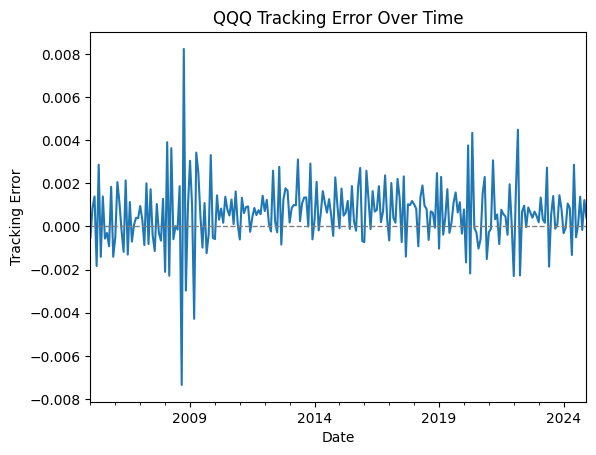

In [6]:
# Tracking Error Plot
plt.figure()
ax = qqq['Tracking_Error'].plot()
add_zero_line(ax)
plt.title('QQQ Tracking Error Over Time')
plt.xlabel('Date'); plt.ylabel('Tracking Error')
plt.show()

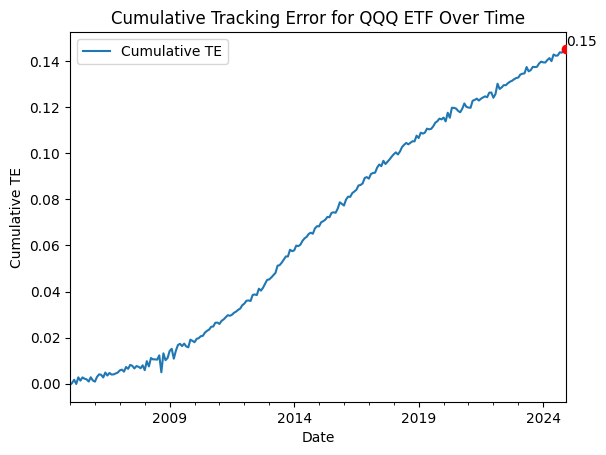

In [7]:
# Cumulative Tracking Error with final‐value marker
cum_te = qqq['Tracking_Error'].cumsum()
plt.figure()
ax = cum_te.plot(label='Cumulative TE')
# Mark & annotate final point
last_date = cum_te.index[-1]
last_val  = cum_te.iloc[-1]
ax.scatter([last_date], [last_val], color='red', zorder=5)
ax.text(last_date, last_val,
        f"{last_val:.2f}",
        va='bottom', ha='left')

plt.title('Cumulative Tracking Error for QQQ ETF Over Time')
plt.xlabel('Date'); plt.ylabel('Cumulative TE')
plt.legend()
plt.show()

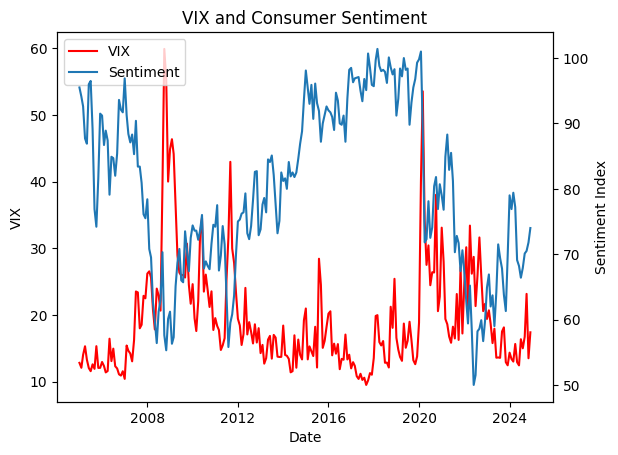

In [8]:
# VIX & Sentiment plots
fig, ax1 = plt.subplots()
ax1.plot(macro['vix'], label='VIX', color='r')
ax1.set_xlabel('Date'); ax1.set_ylabel('VIX')

ax2 = ax1.twinx()
ax2.plot(macro['michigan_consumer_sentiment_index'], label='Sentiment')
ax2.set_ylabel('Sentiment Index')

# combine legends
lines1, labs1 = ax1.get_legend_handles_labels()
lines2, labs2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labs1+labs2, loc='upper left')
plt.title('VIX and Consumer Sentiment')
plt.show()

# SARIMA-GARCH Model Fitting

### Transforms & Inverses Functions

In [9]:
def winsorize_yj(
    series: pd.Series,
    limits: tuple = (0.01, 0.01)
) -> tuple[np.ndarray, dict]:
    """
    Winsorizes the series, shifts it to be strictly positive, 
    and applies the Yeo-Johnson transformation.

    Parameters
    ----------
    series : pd.Series
        Input time series to transform.
    limits : tuple, default (0.01, 0.01)
        Tuple specifying the lower and upper percentile limits 
        for winsorization.

    Returns
    -------
    transformed : np.ndarray
        Transformed series after winsorization, shift, and Yeo-Johnson transform.
    params : dict
        Dictionary containing the transformation parameters:
        - 'lambda': Optimal lambda for the Yeo-Johnson transformation.
        - 'shift': Amount added to shift data to strictly positive.
    """
    w = winsorize(series.values, limits=limits)  # Winsorize outliers
    s_w = pd.Series(w, index=series.index)

    shift = -s_w.min() + 1e-6  # Ensure data is strictly positive
    shifted = s_w + shift

    lam = yeojohnson_normmax(shifted)  # Find optimal lambda
    transformed = yeojohnson(shifted, lmbda=lam)

    return transformed, {"lambda": lam, "shift": shift}


def inv_yj(arr: np.ndarray, params: dict) -> np.ndarray:
    """
    Applies the inverse of the Yeo-Johnson transformation.

    Parameters
    ----------
    arr : np.ndarray
        Transformed array to invert.
    params : dict
        Dictionary containing transformation parameters:
        - 'lambda': Lambda used during the forward transformation.
        - 'shift': Shift applied before transformation.

    Returns
    -------
    y : np.ndarray
        Original array, inverse-transformed and unshifted.
    """
    lam = params["lambda"]
    sh = params["shift"]

    x = np.asarray(arr, dtype=float)
    y = np.zeros_like(x)

    # Positive branch of the inverse
    pos = x >= 0
    if lam != 0:
        y[pos] = np.power(x[pos] * lam + 1, 1 / lam) - 1
    else:
        y[pos] = np.exp(x[pos]) - 1

    # Negative branch of the inverse
    neg = x < 0
    if lam != 2:
        y[neg] = 1 - np.power(-x[neg] * (2 - lam) + 1, 1 / (2 - lam))
    else:
        y[neg] = 1 - np.exp(-x[neg])

    return y - sh

### SARIMA-GARCH Model

In [10]:
def fit_sarima_garch(
    series: pd.Series,
    horizon: int = 3,
    cv_window: int = 60,
    cv_step: int = 30,
    winsor_limits: tuple = (0.01, 0.01),
    seasonal_period: int = 12,
    n_jobs: int = -1,
    arima_jobs: int = 1,
    max_pq: int = 5,
    max_dD: int = 3,
    forecast_plot: bool = True,
) -> dict:
    """
    Fits a SARIMA model with expanding-window cross-validation, and
    optionally visualizes the final CV fold with GARCH-based 95% confidence intervals.

    Parameters
    ----------
    series : pd.Series
        Time series to model.
    horizon : int
        Forecast horizon (steps ahead).
    cv_window : int
        Initial training window for expanding-window CV.
    cv_step : int
        Step size between CV folds.
    winsor_limits : tuple
        Winsorization limits for outlier treatment.
    seasonal_period : int
        Seasonal period for SARIMA.
    n_jobs : int
        Number of parallel jobs for CV folds.
    arima_jobs : int
        Number of parallel jobs inside each auto_arima fit.
    max_pq : int
        Maximum AR/MA and SAR/SMA order.
    max_dD : int
        Maximum differencing order (regular and seasonal).
    forecast_plot : bool
        If True, plots final CV fold forecast with GARCH 95% CI.

    Returns
    -------
    dict
        Dictionary containing:
        - 'cv_metrics': Cross-validation performance metrics (MAE, MSE, R2).
    """

    # ─────────────────────────────────────────────────────────────
    # 0. Data Preparation and Window Setup
    # ─────────────────────────────────────────────────────────────
    y = series.dropna()

    if len(y) < cv_window + horizon:
        raise ValueError("Series too short for chosen cv_window + horizon.")

    # Define fold endpoints for expanding-window CV
    fold_ends = list(range(cv_window, len(y) - horizon + 1, cv_step))
    if fold_ends[-1] != len(y) - horizon:
        fold_ends.append(len(y) - horizon)

    # ─────────────────────────────────────────────────────────────
    # 1. Cross-Validation Fold Logic
    # ─────────────────────────────────────────────────────────────
    def _cv_fold(end):
        train = y.iloc[:end]
        test  = y.iloc[end:end + horizon]

        # Transform training set (winsorize + Yeo-Johnson)
        tr_t, tf_par = winsorize_yj(train, winsor_limits)

        # Fit SARIMA via auto_arima
        model = auto_arima(
            tr_t,
            seasonal=True, m=seasonal_period,
            information_criterion="bic",
            max_p=max_pq, max_q=max_pq, max_d=max_dD,
            max_P=max_pq, max_Q=max_pq, max_D=max_dD,
            stepwise=True, maxiter=20,
            suppress_warnings=True, error_action="ignore",
            n_jobs=arima_jobs,
        )

        # Forecast and inverse-transform
        forecast = inv_yj(model.predict(horizon), tf_par)

        # Return error metrics
        return (
            mean_absolute_error(test, forecast),
            mean_squared_error(test, forecast),
            r2_score(test, forecast)
        )

    # ─────────────────────────────────────────────────────────────
    # 2. Run CV Across All Folds in Parallel
    # ─────────────────────────────────────────────────────────────
    mae, mse, r2 = map(
        list,
        zip(*Parallel(n_jobs=n_jobs)(delayed(_cv_fold)(e) for e in fold_ends))
    )

    # Aggregate CV results
    cv_metrics = {
        "folds": len(mae),
        "MAE": {"values": mae, "mean": np.mean(mae), "std": np.std(mae)},
        "MSE": {"values": mse, "mean": np.mean(mse), "std": np.std(mse)},
        "R2":  {"values": r2,  "mean": np.mean(r2),  "std": np.std(r2)},
    }

    # ─────────────────────────────────────────────────────────────
    # 3. Plot Final Fold Forecast with GARCH Confidence Intervals
    # ─────────────────────────────────────────────────────────────
    if forecast_plot:
        end   = fold_ends[-1]
        train = y.iloc[:end]
        test  = y.iloc[end:end + horizon]

        # Fit SARIMA on final training fold
        tr_t, tf_par = winsorize_yj(train, winsor_limits)
        model = auto_arima(
            tr_t,
            seasonal=True, m=seasonal_period,
            information_criterion="bic",
            max_p=max_pq, max_q=max_pq, max_d=max_dD,
            max_P=max_pq, max_Q=max_pq, max_D=max_dD,
            stepwise=True, maxiter=20,
            suppress_warnings=True, error_action="ignore",
            n_jobs=arima_jobs,
        )
        fc = inv_yj(model.predict(horizon), tf_par)

        # Fit GARCH(1,1) to SARIMA residuals
        resid = pd.Series(model.arima_res_.resid,
                          index=train.index[-len(model.arima_res_.resid):])
        z = resid / resid.std()

        gmod = arch_model(z, vol="Garch", p=1, q=1, dist="t", rescale=False).fit(disp="off")
        var_h   = gmod.forecast(horizon=horizon, reindex=False).variance.iloc[-1].values
        sigma_f = np.sqrt(var_h) * resid.std()

        # Plot the last 10 points + forecast horizon
        prev_n   = 10
        idx_prev = y.index[-(prev_n + horizon): -horizon]

        plt.figure(figsize=(10, 4))
        plt.plot(np.r_[idx_prev, test.index],
                 np.r_[y.loc[idx_prev], test.values],
                 "-o", color="C0", zorder=2, label="Actual")
        plt.plot(np.r_[idx_prev, test.index],
                 np.r_[y.loc[idx_prev].values, fc],
                 "--o", color="C1", zorder=1, label="Forecast")
        plt.errorbar(test.index, fc, yerr=1.96 * sigma_f,
                     fmt="none", ecolor="grey", alpha=0.5,
                     capsize=5, label="GARCH 95% CI")

        plt.title(f"Final CV Fold: SARIMA–GARCH Actual Values + {horizon}-Step Forecast")
        plt.xlabel("Date")
        plt.ylabel(series.name or "Value")
        plt.legend()
        plt.show()

    # ─────────────────────────────────────────────────────────────
    # 4. Return Cross-Validation Metrics
    # ─────────────────────────────────────────────────────────────
    return {"cv_metrics": cv_metrics}


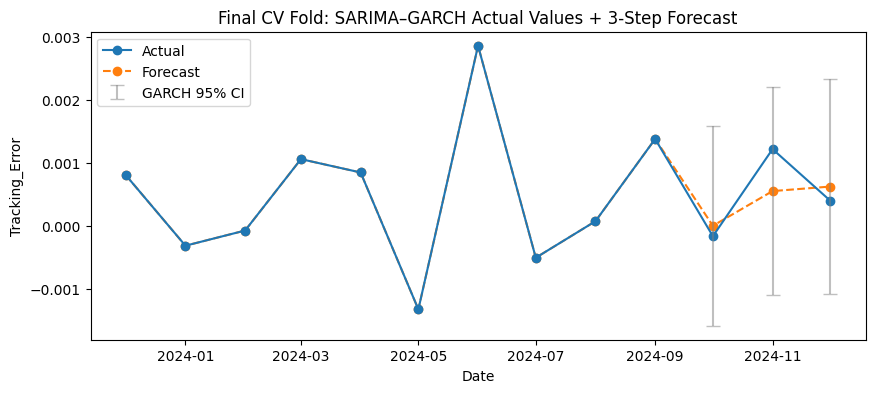

In [11]:
# Fit SARIMA–GARCH model and collect CV metrics
sarima_results = fit_sarima_garch(
    qqq["Tracking_Error"],
    horizon=3,
    cv_window=60,
    cv_step=30,
    forecast_plot=True
)

In [12]:
# Create cross-validation results table (per fold)
sarima_cv_df = pd.DataFrame({
    "Fold": range(1, sarima_results["cv_metrics"]["folds"] + 1),
    "MAE":  sarima_results["cv_metrics"]["MAE"]["values"],
    "MSE":  sarima_results["cv_metrics"]["MSE"]["values"],
    "R2":   sarima_results["cv_metrics"]["R2"]["values"],
})

In [13]:
# Display formatted table
print("\n=== Cross-Validation Results ===")
display(sarima_cv_df.style.format("{:.6f}"))

# Print average performance across all CV folds
print("Average Metrics Across Folds:")
print(f"\nMAE mean ± std : {sarima_results['cv_metrics']['MAE']['mean']:.6f} ± "
      f"{sarima_results['cv_metrics']['MAE']['std']:.6f}")
print(f"MSE mean ± std : {sarima_results['cv_metrics']['MSE']['mean']:.6f} ± "
      f"{sarima_results['cv_metrics']['MSE']['std']:.6f}")
print(f"R2  mean ± std : {sarima_results['cv_metrics']['R2']['mean']:.6f} ± "
      f"{sarima_results['cv_metrics']['R2']['std']:.6f}")


=== Cross-Validation Results ===


,Fold,MAE,MSE,R2
0,1.000000,0.000462,0.000000,0.690292
1,2.000000,0.001213,0.000002,0.059201
2,3.000000,0.000686,0.000001,0.152582
3,4.000000,0.001480,0.000003,-0.061400
4,5.000000,0.002026,0.000006,-0.196206
5,6.000000,0.000225,0.000000,0.583514
6,7.000000,0.000352,0.000000,0.459988


Average Metrics Across Folds:

MAE mean ± std : 0.000921 ± 0.000620
MSE mean ± std : 0.000002 ± 0.000002
R2  mean ± std : 0.241139 ± 0.314097


# MS-SARIMA (VIX Switch) Model Fitting

### VIX Visualisation & Regime Fit

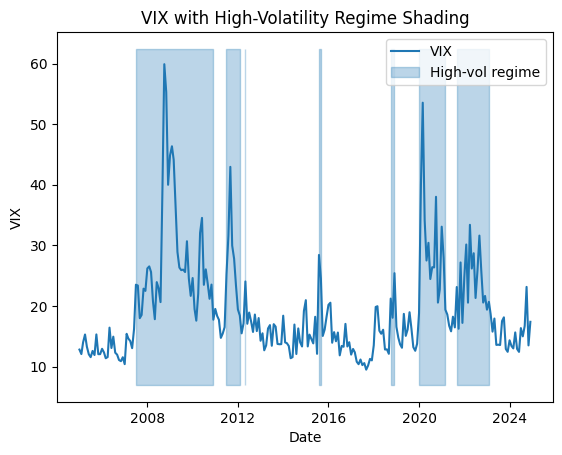

In [14]:
# Extract VIX series from macro data
vix = macro['vix']

# Fit a 2-state Markov switching model on VIX time series
ms_model = MarkovRegression(vix, k_regimes=2, trend='c', switching_variance=True)
ms_res = ms_model.fit(disp=False)

# Extract smoothed probability of high-volatility regime
#    (Assume regime 1 corresponds to high volatility)
s = ms_res.smoothed_marginal_probabilities.iloc[:, 1]


# Plot VIX and overlay shading for high-volatility periods
fig, ax = plt.subplots()
x = vix.index

# Plot the VIX time series
line, = ax.plot(x, vix.values, label='VIX')

# Get vertical axis bounds for shading
ymin, ymax = ax.get_ylim()

# Shade regions where high-volatility regime probability > 0.35
ax.fill_between(
    x,
    ymin,
    ymax,
    where=(s > 0.35),
    color=line.get_color(),
    alpha=0.3,
    label='High-vol regime'
)

# Set axis labels and plot title
ax.set_xlabel('Date')
ax.set_ylabel('VIX')
ax.set_title('VIX with High-Volatility Regime Shading')

# Show legend
ax.legend(loc='upper right')

# Display plot
plt.show()

### VIX Series Standardisation

In [15]:
# Variance-stabilizing transformation using sqrt-log
vix_pre = np.sqrt(np.log1p(vix))

# Z-score standardisation
vix_std = (vix_pre - vix_pre.mean()) / vix_pre.std()

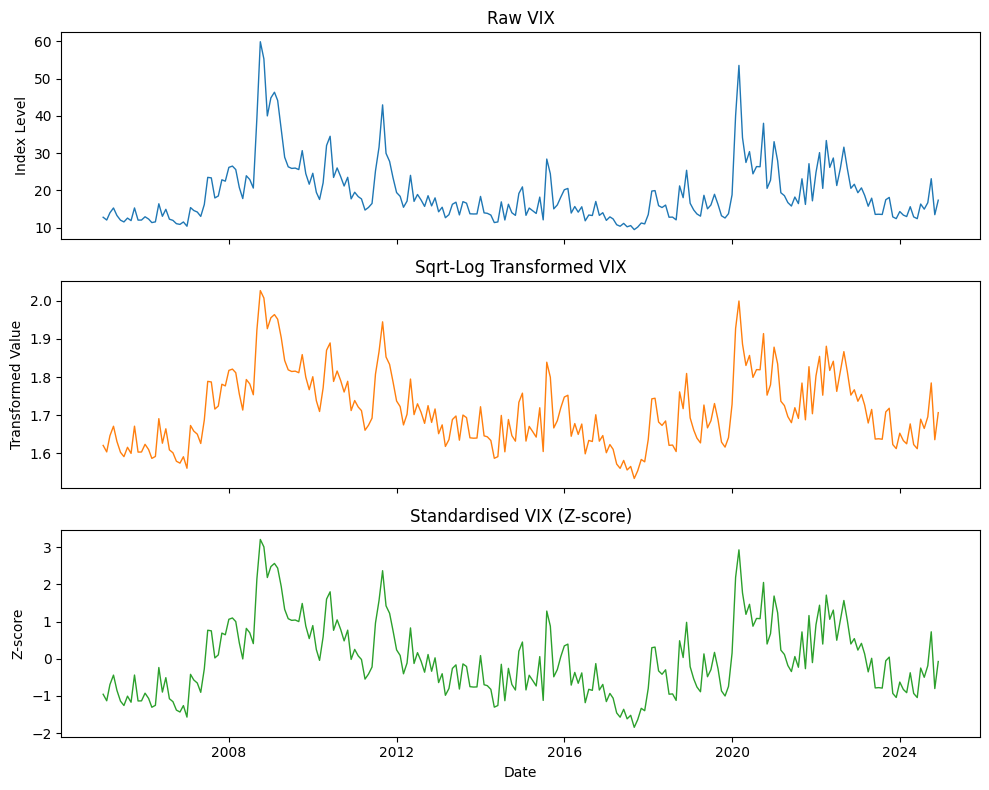

In [16]:
# Plot each series in its own vertical subplot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex=True)

# Plot 1 – Raw VIX
axes[0].plot(vix.index, vix, color='C0', lw=1)
axes[0].set_title("Raw VIX")
axes[0].set_ylabel("Index Level")

# Plot 2 – Variance-stabilized (sqrt-log)
axes[1].plot(vix_pre.index, vix_pre, color='C1', lw=1)
axes[1].set_title("Sqrt‑Log Transformed VIX")
axes[1].set_ylabel("Transformed Value")

# Plot 3 – Z-score standardised VIX
axes[2].plot(vix_std.index, vix_std, color='C2', lw=1)
axes[2].set_title("Standardised VIX (Z-score)")
axes[2].set_ylabel("Z-score")
axes[2].set_xlabel("Date")

# Adjust layout
plt.tight_layout()
plt.show()

### MS SARIMA Model

In [17]:
def fit_ms_sarima_vix(
    series: pd.Series,
    vix: pd.Series,
    horizon: int = 3,
    cv_window: int = 60,
    cv_step: int = 30,
    winsor_limits: tuple = (0.01, 0.01),
    seasonal_period: int = 12,
    regime_thresh: float = 0.5,
    n_jobs: int = -1,
    arima_jobs: int = 1,
    max_pq: int = 5,
    max_dD: int = 3,
    forecast_plot: bool = True,
):
    """
    Fits a two-regime VIX-driven SARIMA model with expanding-window cross-validation.
    Regime switching is driven by a 2-state Markov model on the VIX series.
    Returns only cross-validation metrics. Optionally plots the final fold forecast
    with regime-shaded background and GARCH-based confidence intervals.

    Parameters
    ----------
    series : pd.Series
        Target time series (e.g., ETF tracking error).
    vix : pd.Series
        VIX index (used to infer volatility regimes).
    horizon : int
        Forecast horizon in time steps.
    cv_window : int
        Size of the initial training window.
    cv_step : int
        Step size for expanding-window CV.
    winsor_limits : tuple
        Winsorisation limits before transformation.
    seasonal_period : int
        Seasonal cycle length for SARIMA.
    regime_thresh : float
        Threshold for classifying high-volatility regimes.
    n_jobs : int
        Number of parallel jobs across CV folds.
    arima_jobs : int
        Number of threads for each auto_arima fit.
    max_pq : int
        Maximum p/q/P/Q orders for SARIMA.
    max_dD : int
        Maximum d/D differencing orders for SARIMA.
    forecast_plot : bool
        If True, plots the final fold forecast with regime shading and CI.

    Returns
    -------
    dict
        Dictionary containing:
        - 'cv_metrics': Cross-validation error metrics (MAE, MSE, R²).
    """

    # ─────────────────────────────────────────────────────────────
    # 0. Data Preparation and Fold Definitions
    # ─────────────────────────────────────────────────────────────
    y = series.dropna()
    v = vix.reindex_like(y).fillna(method="ffill")

    if len(y) < cv_window + horizon:
        raise ValueError("Series too short for chosen cv_window + horizon.")

    # Ensure final fold ends at len(y) - horizon
    fold_ends = list(range(cv_window, len(y) - horizon + 1, cv_step))
    if fold_ends[-1] != len(y) - horizon:
        fold_ends.append(len(y) - horizon)

    # ─────────────────────────────────────────────────────────────
    # Helper: Fit SARIMA on a given subset
    # ─────────────────────────────────────────────────────────────
    def _sarima_fit(ts):
        ts_t, tf_par = winsorize_yj(ts, winsor_limits)
        mod = auto_arima(
            ts_t,
            seasonal=True, m=seasonal_period,
            information_criterion="bic",
            max_p=max_pq, max_q=max_pq, max_d=max_dD,
            max_P=max_pq, max_Q=max_pq, max_D=max_dD,
            stepwise=True, maxiter=20,
            suppress_warnings=True, error_action="ignore",
            n_jobs=arima_jobs,
        )
        fc = inv_yj(mod.predict(horizon), tf_par)
        return mod, tf_par, fc

    # ─────────────────────────────────────────────────────────────
    # Helper: Fit Markov switching model on VIX
    # ─────────────────────────────────────────────────────────────
    def _regimes(v_sub):
        res = MarkovRegression(v_sub, k_regimes=2, trend="c", switching_variance=True).fit(disp=False)
        p00, p10 = res.params["p[0->0]"], res.params["p[1->0]"]
        P = np.array([[p00, 1 - p00], [p10, 1 - p10]])
        prob_high = res.smoothed_marginal_probabilities.iloc[:, 1]
        return prob_high, P

    # ─────────────────────────────────────────────────────────────
    # 1. Cross-Validation Fold Worker
    # ─────────────────────────────────────────────────────────────
    def _cv_fold(end):
        y_tr, y_te = y.iloc[:end], y.iloc[end:end + horizon]
        prob, P = _regimes(v.iloc[:end])
        flag = prob > regime_thresh  # High-volatility flag

        # Fit regime-specific SARIMA models
        if flag.all() or (~flag).all():
            lo_mod, lo_tf, lo_fc = _sarima_fit(y_tr)
            hi_mod, hi_tf, hi_fc = lo_mod, lo_tf, lo_fc
        else:
            lo_mod, lo_tf, lo_fc = _sarima_fit(y_tr.loc[~flag])
            hi_mod, hi_tf, hi_fc = _sarima_fit(y_tr.loc[ flag])

        # Regime-mixed forecast over horizon
        p_vec = np.array([1 - prob.iloc[-1], prob.iloc[-1]])
        fc_mix = []
        for h in range(horizon):
            p_vec = p_vec @ P
            fc_mix.append(p_vec[0] * lo_fc[h] + p_vec[1] * hi_fc[h])

        return (
            mean_absolute_error(y_te, fc_mix),
            mean_squared_error(y_te, fc_mix),
            r2_score(y_te, fc_mix)
        )

    # ─────────────────────────────────────────────────────────────
    # 2. Run Cross-Validation (Parallelized)
    # ─────────────────────────────────────────────────────────────
    mae, mse, r2 = map(
        list,
        zip(*Parallel(n_jobs=n_jobs)(delayed(_cv_fold)(e) for e in fold_ends))
    )

    cv_metrics = {
        "folds": len(mae),
        "MAE": {"values": mae, "mean": np.mean(mae), "std": np.std(mae)},
        "MSE": {"values": mse, "mean": np.mean(mse), "std": np.std(mse)},
        "R2":  {"values": r2,  "mean": np.mean(r2),  "std": np.std(r2)},
    }

    # ─────────────────────────────────────────────────────────────
    # 3. Optional Final Fold Forecast Plot
    # ─────────────────────────────────────────────────────────────
    if forecast_plot:
        tr_y, te_y = y.iloc[:-horizon], y.iloc[-horizon:]
        prob_f, P_f = _regimes(v.iloc[:-horizon])
        flag_f = prob_f > regime_thresh

        if flag_f.all() or (~flag_f).all():
            lo_mod, lo_tf, lo_fc = _sarima_fit(tr_y)
            hi_mod, hi_tf, hi_fc = lo_mod, lo_tf, lo_fc
        else:
            lo_mod, lo_tf, lo_fc = _sarima_fit(tr_y.loc[~flag_f])
            hi_mod, hi_tf, hi_fc = _sarima_fit(tr_y.loc[ flag_f])

        # Helper: Estimate forecast std using GARCH(1,1)
        def _sigma(mod, sub_series):
            resid = pd.Series(mod.arima_res_.resid,
                              index=sub_series.index[-len(mod.arima_res_.resid):])
            z = resid / resid.std()
            gfit = arch_model(z, vol="Garch", p=1, q=1, dist="t", rescale=False).fit(disp="off")
            var_h = gfit.forecast(horizon=horizon, reindex=False).variance.iloc[-1]
            return np.sqrt(var_h) * resid.std()

        sig_lo = _sigma(lo_mod, tr_y.loc[~flag_f] if (~flag_f).any() else tr_y)
        sig_hi = _sigma(hi_mod, tr_y.loc[ flag_f] if  flag_f.any()  else tr_y)

        # Regime-weighted forecast and uncertainty
        p_vec = np.array([1 - prob_f.iloc[-1], prob_f.iloc[-1]])
        fc_mix, sigma_mix = [], []
        for h in range(horizon):
            p_vec = p_vec @ P_f
            fc_mix.append(p_vec[0] * lo_fc[h] + p_vec[1] * hi_fc[h])
            sigma_mix.append(np.sqrt(p_vec[0] * sig_lo[h]**2 + p_vec[1] * sig_hi[h]**2))

        # Plot final-fold results
        prev_n   = 10
        idx_prev = y.index[-(prev_n + horizon):-horizon]

        plt.figure(figsize=(10, 4))
        plt.plot(np.r_[idx_prev, te_y.index],
                 np.r_[y.loc[idx_prev], te_y.values],
                 "-o", color="C0", label="Actual", zorder=2)
        plt.plot(np.r_[idx_prev, te_y.index],
                 np.r_[y.loc[idx_prev].values, fc_mix],
                 "--o", color="C1", label="Forecast", zorder=1)
        plt.errorbar(te_y.index, fc_mix, yerr=1.96 * np.array(sigma_mix),
                     fmt="none", ecolor="grey", alpha=0.5, capsize=5,
                     label="GARCH 95% CI")

        # Regime shading (high-volatility areas)
        shade = pd.concat([
            prob_f.iloc[-prev_n:],  # Last 10 steps
            pd.Series([p_vec[1]] * horizon, index=te_y.index)
        ])
        ymin, ymax = plt.ylim()
        plt.fill_between(shade.index, ymin, ymax,
                         where=shade > regime_thresh,
                         color="C2", alpha=0.3, label="High-Vol Regime")

        plt.title(f"Final CV Fold: MS-SARIMA ({horizon}-step)")
        plt.xlabel("Date")
        plt.ylabel(series.name or "Value")
        plt.legend(loc="upper left")
        plt.show()

    # ─────────────────────────────────────────────────────────────
    # 4. Return Cross-Validation Results
    # ─────────────────────────────────────────────────────────────
    return {"cv_metrics": cv_metrics}


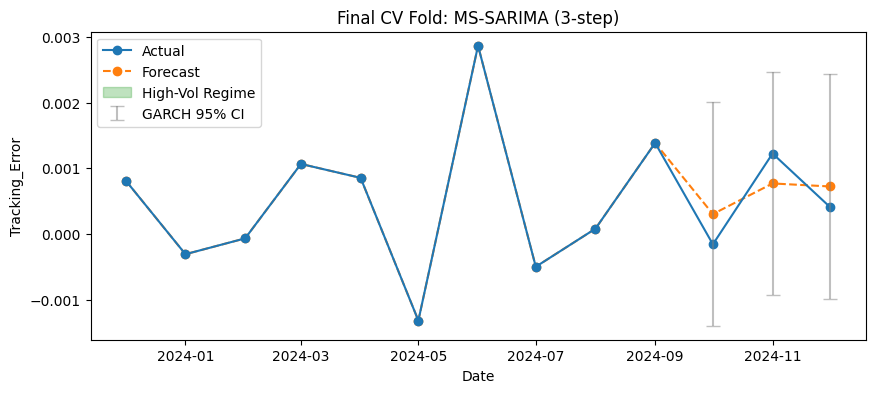

In [18]:
# Fit MS-VIX-SARIMA model and collect CV metrics
ms_vix_sarima_results = fit_ms_sarima_vix(
    series = qqq["Tracking_Error"],
    vix    = vix_std,
    horizon=3,
    cv_window=60,
    cv_step=30,
    regime_thresh=0.5,
    forecast_plot=True
)

In [19]:
# Create cross-validation results table
print("\n=== Cross-Validation Results ===")
ms_vix_sarima_cv_df = pd.DataFrame({
    "Fold": range(1, ms_vix_sarima_results["cv_metrics"]["folds"] + 1),
    "MAE":  ms_vix_sarima_results["cv_metrics"]["MAE"]["values"],
    "MSE":  ms_vix_sarima_results["cv_metrics"]["MSE"]["values"],
    "R2":   ms_vix_sarima_results["cv_metrics"]["R2"]["values"],
})
display(ms_vix_sarima_cv_df.style.format("{:.6f}"))

# Print average metrics across folds
for k in ["MAE", "MSE", "R2"]:
    print(f"{k} mean ± std : {ms_vix_sarima_results['cv_metrics'][k]['mean']:.6f} ± "
          f"{ms_vix_sarima_results['cv_metrics'][k]['std']:.6f}")


=== Cross-Validation Results ===


,Fold,MAE,MSE,R2
0,1.000000,0.000461,0.000000,0.685336
1,2.000000,0.001208,0.000002,0.075862
2,3.000000,0.000629,0.000000,0.264311
3,4.000000,0.001595,0.000003,-0.098989
4,5.000000,0.001847,0.000005,0.039159
5,6.000000,0.000174,0.000000,0.770925
6,7.000000,0.000411,0.000000,0.461657


MAE mean ± std : 0.000903 ± 0.000598
MSE mean ± std : 0.000002 ± 0.000002
R2 mean ± std : 0.314037 ± 0.310242
